In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

You can change these parameters to test different datasets, filters, and slices:

- `original_filename`: Path to the original input data file.
- `wavelet_name`: Type of wavelet to use (e.g., 'db2').
- `levels`: Number of levels for the wavelet transform.
- `slice`: Slice to observe (along depth).

In [2]:
# Dataset to use
Dataset = 'CT'

# Choose MR type (T1DUAL/T2SPIR) (irrelevant if Dataset = 'CT')
MR_type = 'T1DUAL'

# Chose Phase (irrelevant if MR_type = 'T1DUAL')
phase = 'InPhase'

# Number attached to set of data
Dataset_num = '3'

# Type of wavelet to use
wavelet_name = 'db4'

# Number of levels 
levels = 2

# Slice to observe (along depth)
slice = 1

In [3]:
if Dataset == 'CT':
    filename = f'{Dataset_num}_{Dataset}'
elif MR_type == 'T1DUAL':
    filename = f'{Dataset_num}_{Dataset}_{MR_type}_{phase}'
else:
    filename = f'{Dataset_num}_{Dataset}_{MR_type}'

# Read the original input data
original_filename = f'../data/inputs/{filename}.bin'

This Python script performs a comparison of each level of the Discrete Wavelet Transform (DWT). It plots the subbands and calculates the Mean Squared Error (MSE) for all subbands as well as the MSE of the total energy. Additionally, it displays the resolutions of each subband at each level.

In [4]:
# Read the shape of the original data
def read_shape_file(shape_filename):
    with open(shape_filename, 'r') as f:
        shape = tuple(map(int, f.read().strip().split(',')))
    return shape

# Read the original data
def read_binary_file(filename):
    # Determine the shape file name based on the binary file name
    shape_filename = filename.rsplit('.', 1)[0] + "_shape.txt"
    
    # Read the shape information
    depth, rows, cols = read_shape_file(shape_filename)
    print(f"Read dimensions from shape file: depth={depth}, rows={rows}, cols={cols}")
    
    # Read the binary file
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.float32)
        print(f"Read data size: {data.size}")
        
        data = data.reshape((depth, rows, cols))
        
    return data

# Read the result of the C++ implementation
def read_wavelet3d_result(filename):
    # Determine the output file name by appending "out" to the input file name
    output_filename = "../data/outputs/" + filename.rsplit('/', 1)[-1].rsplit('.', 1)[0] + "_" + wavelet_name + "_" + str(levels) + "." + filename.rsplit('.', 1)[1]
    
    subbands = {}
    with open(output_filename, 'rb') as file:
        for key in ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']:
            depth = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            rows = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            cols = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            data = np.fromfile(file, dtype=np.float32, count=depth*rows*cols)
            data = data.reshape((depth, rows, cols))
            subbands[key] = data
    return subbands

In [5]:
# Normalise the data so that it is more visually appealing
def normalise_plot(value):

    value = np.abs(value)

    return value

# Function to pad arrays to match shapes
def pad(array, target_shape):
    pad_width = [(0, max(0, t - s)) for s, t in zip(array.shape, target_shape)]
    return np.pad(array, pad_width, mode='constant')

def display_images(data_cpp, data_pywt, title, keys_cpp, keys_pywt, slice_idx):
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))  # 4 rows, 4 columns (8 pairs)
    fig.suptitle(title, fontsize=16)

    for i, key_cpp in enumerate(keys_cpp):
        if key_cpp not in data_cpp:
            print(f"Key '{key_cpp}' not found in C++ data")
            continue
        
        # Check if the slice index is within bounds for C++ data
        if slice_idx >= data_cpp[key_cpp].shape[0]:
            print(f"Slice index {slice_idx} is out of bounds for key '{key_cpp}' in C++ data with size {data_cpp[key_cpp].shape[0]}")
            continue
        
        # Determine the row and column positions for the images
        row = i // 2  # 4 rows
        col_cpp = (i % 2) * 2  # C++ image on the left side of each pair
        col_pywt = col_cpp + 1  # pywt image on the right side of each pair

        # Display the C++ image
        value_cpp = data_cpp[key_cpp][slice_idx]
        value_cpp = normalise_plot(value_cpp)
        ax_cpp = axes[row, col_cpp]
        ax_cpp.imshow(value_cpp, cmap='gray')
        ax_cpp.set_title(f'C++ - {key_cpp}')
        ax_cpp.axis('off')

        # Check if the corresponding PyWavelet key exists and display it
        key_pywt = keys_pywt[i] if i < len(keys_pywt) else None
        if key_pywt and key_pywt in data_pywt:
            # Display the pywt image if it exists
            value_pywt = data_pywt[key_pywt][slice_idx]
            value_pywt = normalise_plot(value_pywt)
            ax_pywt = axes[row, col_pywt]
            ax_pywt.imshow(value_pywt, cmap='gray')
            ax_pywt.set_title(f'pywt - {key_pywt}')
            ax_pywt.axis('off')
        else:
            # If the PyWavelet key doesn't exist, leave the second axis empty
            ax_pywt = axes[row, col_pywt]
            ax_pywt.axis('off')  # Hide the axis when not displaying anything

    # Adjust layout and remove space between the images
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(wspace=0, hspace=0.3)
    plt.show()


# Perform the multi-level 3D wavelet transform using PyWavelets
def multi_pywt_3d(data, wavelet, mode, levels):
    coeffs = pywt.wavedecn(data, wavelet=wavelet, mode=mode, level=levels)
    return coeffs

In [ ]:
# Print filter coefficients
wavelet = pywt.Wavelet(wavelet_name)
print(f"Low-pass filter coefficients for {wavelet_name}: {wavelet.dec_lo}")
print(f"High-pass filter coefficients for {wavelet_name}: {wavelet.dec_hi}")

Low-pass filter coefficients for db4: [-0.010597401785069032, 0.0328830116668852, 0.030841381835560764, -0.18703481171909309, -0.027983769416859854, 0.6308807679298589, 0.7148465705529157, 0.2303778133088965]
High-pass filter coefficients for db4: [-0.2303778133088965, 0.7148465705529157, -0.6308807679298589, -0.027983769416859854, 0.18703481171909309, 0.030841381835560764, -0.0328830116668852, -0.010597401785069032]


In [7]:
# Read the original data
original_data = read_binary_file(original_filename)

# Perform the multi-level 3D wavelet transform using PyWavelets
coeffs_pywt = multi_pywt_3d(original_data, wavelet=wavelet_name, mode='periodization', levels=levels)

# Read the results from the C++ implementation
data_cpp = read_wavelet3d_result(original_filename)

Read dimensions from shape file: depth=78, rows=512, cols=512


Read data size: 20447232


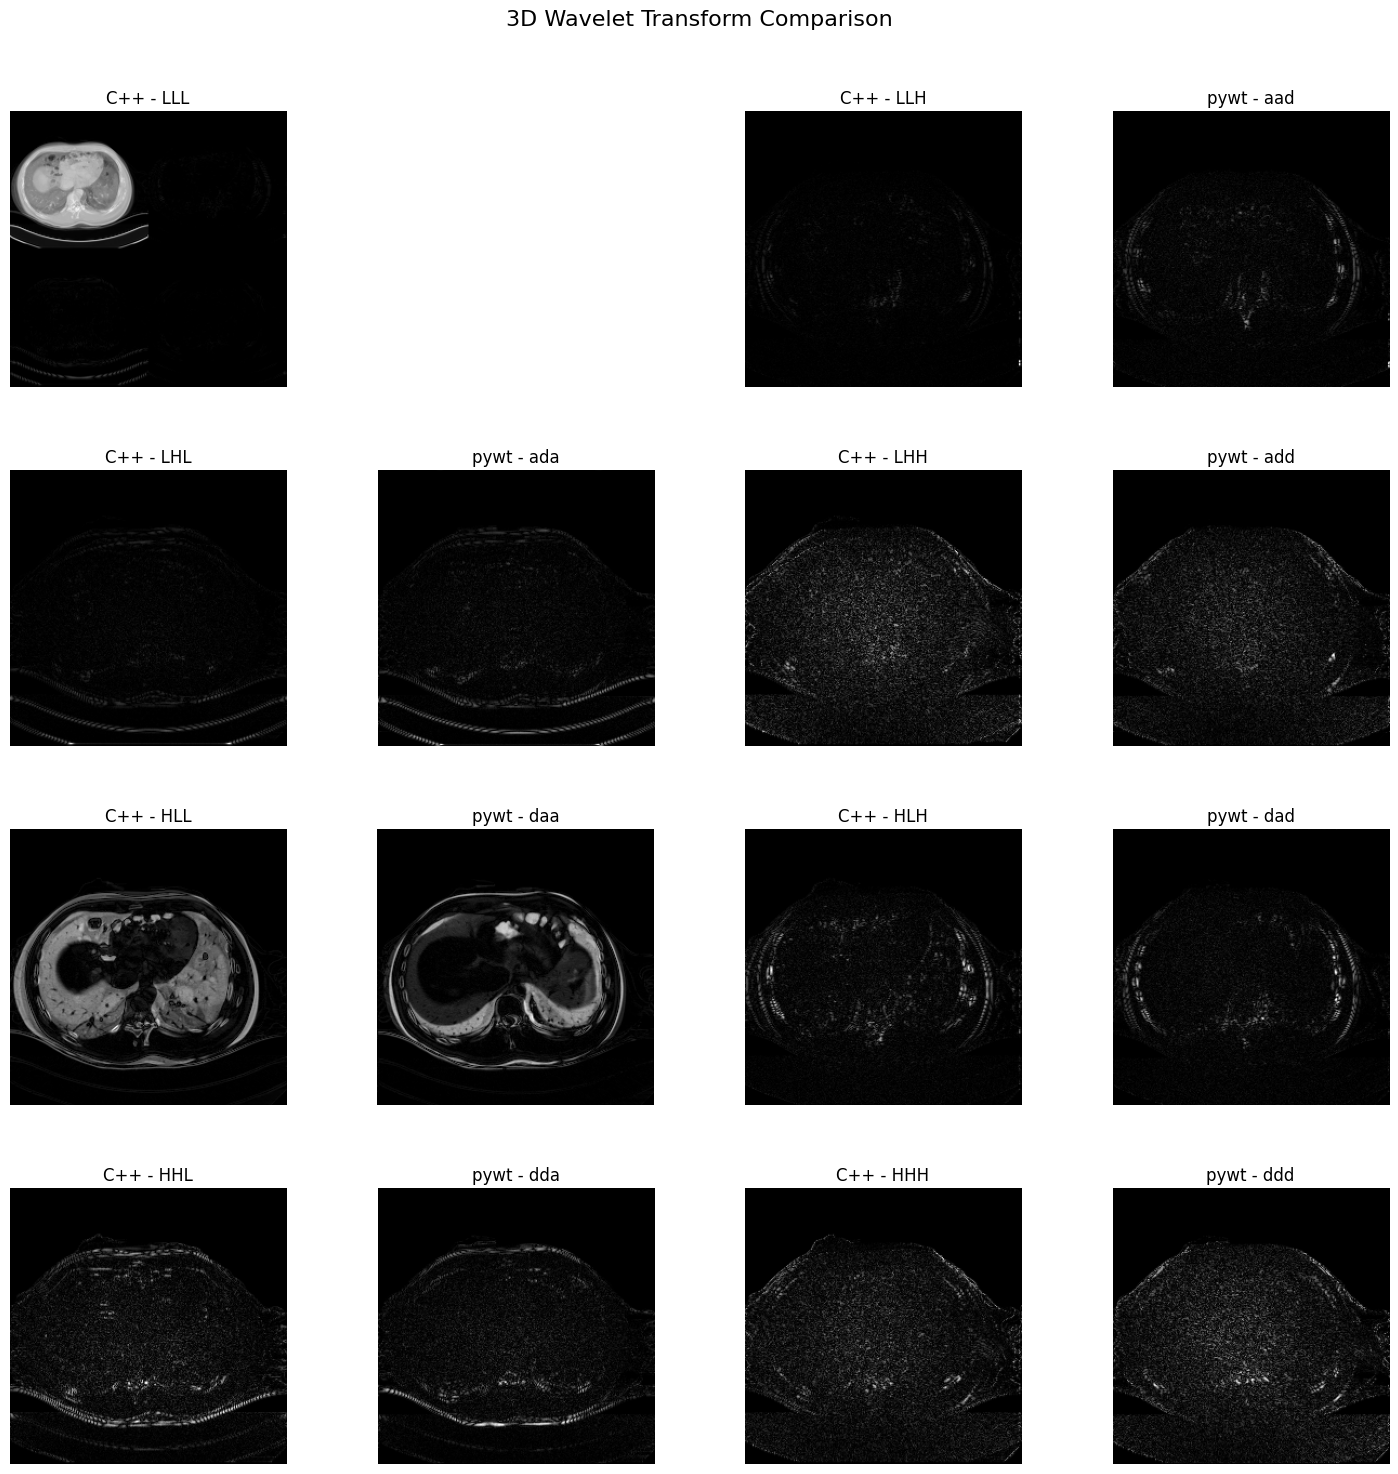

In [8]:
# Extract the subbands from the first level
pywt = coeffs_pywt[levels]

# If we only have one level, extract the aaa subband
if levels == 1:
    pywt_aaa = coeffs_pywt[0]  # Extract the aaa subband

    # Add the aaa subband to pywt for display
    pywt['aaa'] = pywt_aaa

# Display the subbands related to this level for both pywt and C++ implementation
display_images(data_cpp, pywt, '3D Wavelet Transform Comparison', 
               keys_cpp=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'], 
               keys_pywt=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'], 
               slice_idx=slice)

In [9]:
# Copy the data to new arrays
data_cpp_copy = {key: np.copy(value) for key, value in data_cpp.items()}
coeffs_pywt_copy = {key: np.copy(value) for key, value in pywt.items()}

# Map between C++ keys and PyWavelets keys
cpp_to_pywt_keys = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Compare pywavlets and C++ results
total_energy_cpp = 0
total_energy_pywt = 0
for cpp_key, pywt_key in cpp_to_pywt_keys.items():
    try:
        cpp_data_copy = data_cpp_copy[cpp_key]
        pywt_data_copy = coeffs_pywt_copy[pywt_key]
        
        # Pad arrays to match shapes if necessary
        if cpp_data_copy.shape != pywt_data_copy.shape:
            if cpp_data_copy.shape < pywt_data_copy.shape:
                cpp_data_copy = pad(cpp_data_copy, pywt_data_copy.shape)
            else:
                pywt_data_copy = pad(pywt_data_copy, cpp_data_copy.shape)
        
        mse = np.mean((cpp_data_copy - pywt_data_copy) ** 2)
        print(f"MSE for {cpp_key}: {mse}")
        
    except KeyError as e:
        print(f"KeyError: {e} for key {cpp_key}")



KeyError: 'aaa' for key LLL
MSE for LLH: 1260.6158447265625
MSE for LHL: 4082.621337890625
MSE for LHH: 214.66070556640625
MSE for HLL: 275146.0
MSE for HLH: 1068.674560546875
MSE for HHL: 1772.9796142578125
MSE for HHH: 193.35032653808594


In [10]:
print ("Resolution of subbands from PyWavelets:")

# Printing the resolution of the subbands
for key, value in pywt.items():
    print(f"Resolution of subband {key}: {value.shape}")

print ("\nResolution of subbands from C++:")

for key, value in data_cpp.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subbands from PyWavelets:
Resolution of subband aad: (39, 256, 256)
Resolution of subband ada: (39, 256, 256)
Resolution of subband add: (39, 256, 256)
Resolution of subband daa: (39, 256, 256)
Resolution of subband dad: (39, 256, 256)
Resolution of subband dda: (39, 256, 256)
Resolution of subband ddd: (39, 256, 256)

Resolution of subbands from C++:
Resolution of subband LLL: (39, 256, 256)
Resolution of subband LLH: (39, 256, 256)
Resolution of subband LHL: (39, 256, 256)
Resolution of subband LHH: (39, 256, 256)
Resolution of subband HLL: (39, 256, 256)
Resolution of subband HLH: (39, 256, 256)
Resolution of subband HHL: (39, 256, 256)
Resolution of subband HHH: (39, 256, 256)


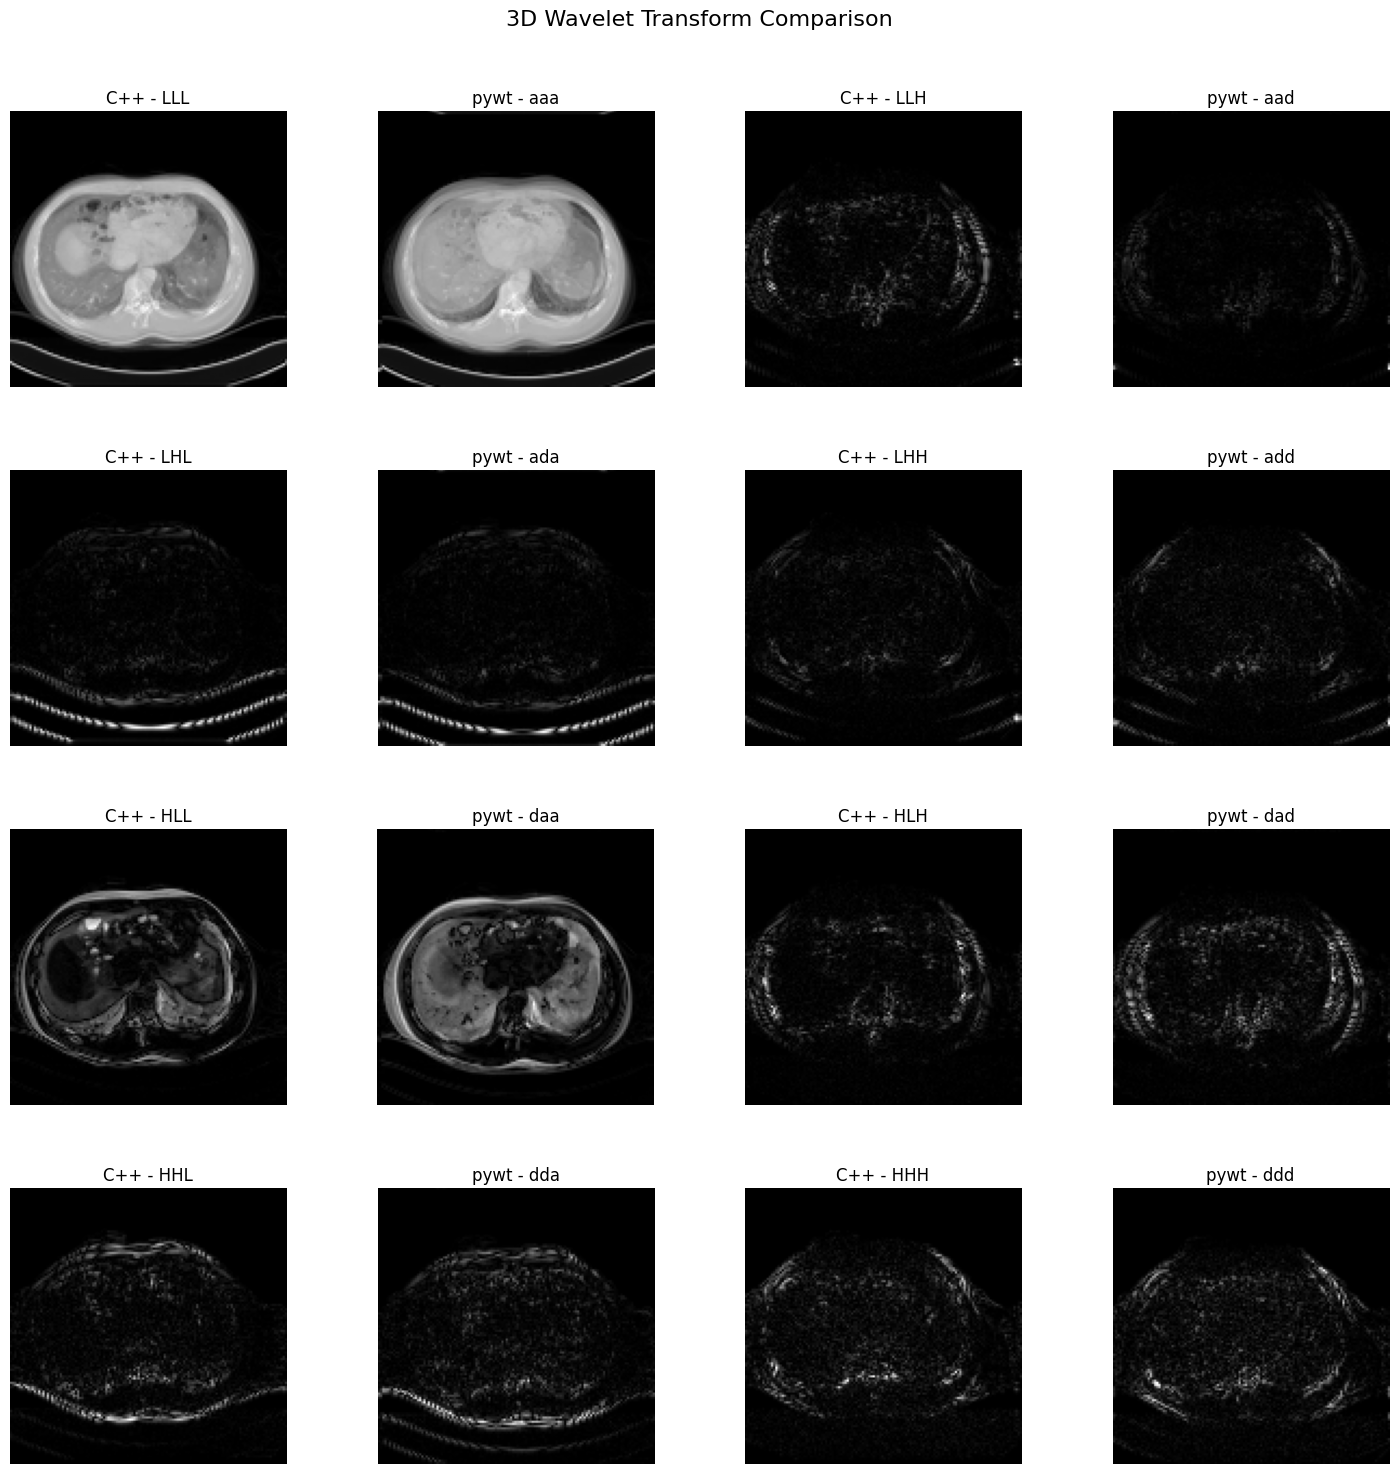

In [11]:
# Extract the LLL subband from the first level
LLL_subband = data_cpp['LLL']

# Get the dimensions of the LLL subband
depth, rows, cols = LLL_subband.shape

# Use ceil to handle odd dimensions correctly
half_depth = int(np.ceil(depth / 2))
half_rows = int(np.ceil(rows / 2))
half_cols = int(np.ceil(cols / 2))

# Extract the subbands from the second level LLL subband
subbands_level2 = {
    'LLL': LLL_subband[:half_depth, :half_rows, :half_cols],
    'LLH': LLL_subband[:half_depth, :half_rows, half_cols:],
    'LHL': LLL_subband[:half_depth, half_rows:, :half_cols],
    'LHH': LLL_subband[:half_depth, half_rows:, half_cols:],
    'HLL': LLL_subband[half_depth:, :half_rows, :half_cols],
    'HLH': LLL_subband[half_depth:, :half_rows, half_cols:],
    'HHL': LLL_subband[half_depth:, half_rows:, :half_cols],
    'HHH': LLL_subband[half_depth:, half_rows:, half_cols:]
}

# If the preivous level was the last, exit
if levels - 1 < 1:
    print("Finished Multi-Level Wavelet Transform")
    exit(1)

else:
    pywt = coeffs_pywt[levels-1]

    # If this is the last level, extract the aaa subband
    if levels - 1 == 1:
        pywt_aaa = coeffs_pywt[0]  # Extract the aaa subband

        # Add the aaa subband to pywt_level2 for display
        pywt['aaa'] = pywt_aaa

# Display the subbands related to this level for both pywt and C++ implementation
display_images(subbands_level2, pywt, '3D Wavelet Transform Comparison', 
               keys_cpp=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'], 
               keys_pywt=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'], 
               slice_idx=slice)

In [12]:
# Copy the data to new arrays
data_cpp_copy = {key: np.copy(value) for key, value in subbands_level2.items()}
coeffs_pywt_copy = {key: np.copy(value) for key, value in pywt.items()}


# Mapping between C++ keys and PyWavelets keys
cpp_to_pywt_keys = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Compare pywavlets and C++ results
total_energy_cpp = 0
total_energy_pywt = 0
for cpp_key, pywt_key in cpp_to_pywt_keys.items():
    try:
        cpp_data_copy = data_cpp_copy[cpp_key]
        pywt_data_copy = coeffs_pywt_copy[pywt_key]
        
        # Pad arrays to match shapes if necessary
        if cpp_data_copy.shape != pywt_data_copy.shape:
            if cpp_data_copy.shape < pywt_data_copy.shape:
                cpp_data_copy = pad(cpp_data_copy, pywt_data_copy.shape)
            else:
                pywt_data_copy = pad(pywt_data_copy, cpp_data_copy.shape)
        
        mse = np.mean((cpp_data_copy - pywt_data_copy) ** 2)
        print(f"MSE for {cpp_key}: {mse}")

    except KeyError as e:
        print(f"KeyError: {e} for key {cpp_key}")

MSE for LLL: 4926459.0
MSE for LLH: 26896.890625
MSE for LHL: 184918.921875
MSE for LHH: 6599.7021484375
MSE for HLL: 1792122.0
MSE for HLH: 349986.0
MSE for HHL: 28428.193359375
MSE for HHH: 5659.7421875


In [13]:
print ("Resolution of subbands from PyWavelets:")

for key, value in pywt.items():
    print(f"Resolution of subband {key}: {value.shape}")

print ("\nResolution of subbands from C++:")

for key, value in subbands_level2.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subbands from PyWavelets:
Resolution of subband aad: (20, 128, 128)
Resolution of subband ada: (20, 128, 128)
Resolution of subband add: (20, 128, 128)
Resolution of subband daa: (20, 128, 128)
Resolution of subband dad: (20, 128, 128)
Resolution of subband dda: (20, 128, 128)
Resolution of subband ddd: (20, 128, 128)
Resolution of subband aaa: (20, 128, 128)

Resolution of subbands from C++:
Resolution of subband LLL: (20, 128, 128)
Resolution of subband LLH: (20, 128, 128)
Resolution of subband LHL: (20, 128, 128)
Resolution of subband LHH: (20, 128, 128)
Resolution of subband HLL: (19, 128, 128)
Resolution of subband HLH: (19, 128, 128)
Resolution of subband HHL: (19, 128, 128)
Resolution of subband HHH: (19, 128, 128)


Finished Multi-Level Wavelet Transform


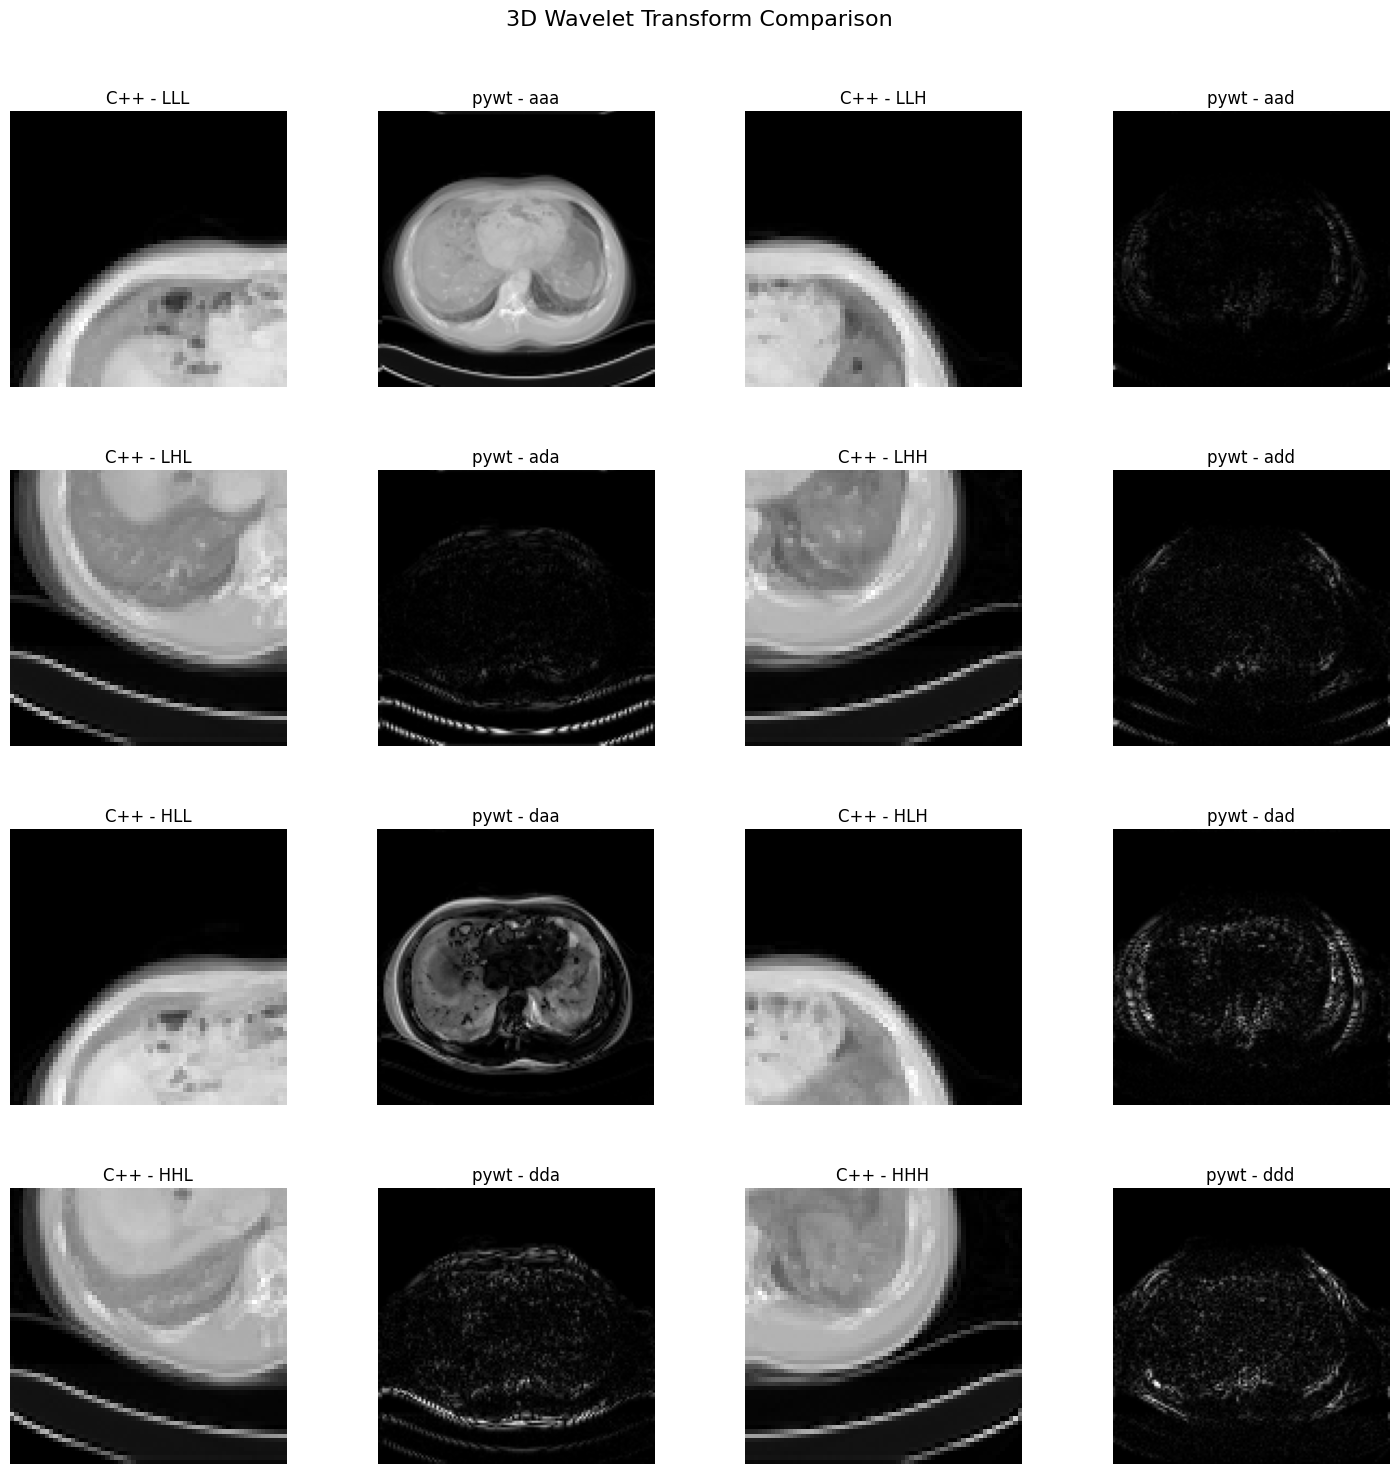

In [14]:
# Extract the LLL subband from the first level
LLL_subband1 = subbands_level2['LLL']

# Get the dimensions of the LLL subband
depth, rows, cols = LLL_subband1.shape

# Use ceil to handle odd dimensions correctly
half_depth = int(np.ceil(depth / 2))
half_rows = int(np.ceil(rows / 2))
half_cols = int(np.ceil(cols / 2))

# Extract the subbands from the second level LLL subband
subbands_level3 = {
    'LLL': LLL_subband1[:half_depth, :half_rows, :half_cols],
    'LLH': LLL_subband1[:half_depth, :half_rows, half_cols:],
    'LHL': LLL_subband1[:half_depth, half_rows:, :half_cols],
    'LHH': LLL_subband1[:half_depth, half_rows:, half_cols:],
    'HLL': LLL_subband1[half_depth:, :half_rows, :half_cols],
    'HLH': LLL_subband1[half_depth:, :half_rows, half_cols:],
    'HHL': LLL_subband1[half_depth:, half_rows:, :half_cols],
    'HHH': LLL_subband1[half_depth:, half_rows:, half_cols:]
}

if levels - 2 < 1:
    print("Finished Multi-Level Wavelet Transform")
    exit(1)

else:
    pywt = coeffs_pywt[levels-2]

    if levels - 2 == 1:
        pywt_aaa = coeffs_pywt[0]  # Extract the aaa subband

        # Add the aaa subband to pywt_level2 for display
        pywt['aaa'] = pywt_aaa

# Display the subbands related to this level for both pywt and C++ implementation
display_images(subbands_level3, pywt, '3D Wavelet Transform Comparison', 
               keys_cpp=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'], 
               keys_pywt=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'], 
               slice_idx=slice)

In [15]:
# Copy the data to new arrays
data_cpp_copy = {key: np.copy(value) for key, value in subbands_level3.items()}
coeffs_pywt_copy = {key: np.copy(value) for key, value in pywt.items()}


# Map between C++ keys and PyWavelets keys
cpp_to_pywt_keys = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Compare pywavlets and C++ results
total_energy_cpp = 0
total_energy_pywt = 0
for cpp_key, pywt_key in cpp_to_pywt_keys.items():
    try:
        cpp_data_copy = data_cpp_copy[cpp_key]
        pywt_data_copy = coeffs_pywt_copy[pywt_key]
        
        # Pad arrays to match shapes if necessary
        if cpp_data_copy.shape != pywt_data_copy.shape:
            if cpp_data_copy.shape < pywt_data_copy.shape:
                cpp_data_copy = pad(cpp_data_copy, pywt_data_copy.shape)
            else:
                pywt_data_copy = pad(pywt_data_copy, cpp_data_copy.shape)
        
        mse = np.mean((cpp_data_copy - pywt_data_copy) ** 2)
        print(f"MSE for {cpp_key}: {mse}")

    except KeyError as e:
        print(f"KeyError: {e} for key {cpp_key}")


MSE for LLL: 24610348.0
MSE for LLH: 2206281.75
MSE for LHL: 4881431.0
MSE for LHH: 3616936.5
MSE for HLL: 3070722.5
MSE for HLH: 1969702.75
MSE for HHL: 4207391.0
MSE for HHH: 3232378.25


In [16]:
print ("Resolution of subbands from PyWavelets:")

# Printing the resolution of the subbands
for key, value in pywt.items():
    print(f"Resolution of subband {key}: {value.shape}")

print ("\nResolution of subbands from C++:")

for key, value in subbands_level3.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subbands from PyWavelets:
Resolution of subband aad: (20, 128, 128)
Resolution of subband ada: (20, 128, 128)
Resolution of subband add: (20, 128, 128)
Resolution of subband daa: (20, 128, 128)
Resolution of subband dad: (20, 128, 128)
Resolution of subband dda: (20, 128, 128)
Resolution of subband ddd: (20, 128, 128)
Resolution of subband aaa: (20, 128, 128)

Resolution of subbands from C++:
Resolution of subband LLL: (10, 64, 64)
Resolution of subband LLH: (10, 64, 64)
Resolution of subband LHL: (10, 64, 64)
Resolution of subband LHH: (10, 64, 64)
Resolution of subband HLL: (10, 64, 64)
Resolution of subband HLH: (10, 64, 64)
Resolution of subband HHL: (10, 64, 64)
Resolution of subband HHH: (10, 64, 64)


In [17]:
# Extract the LLL subband from the first level
LLL_subband2 = subbands_level3['LLL']

# Get the dimensions of the LLL subband
depth, rows, cols = LLL_subband2.shape

# Use ceil to handle odd dimensions correctly
half_depth = int(np.ceil(depth / 2))
half_rows = int(np.ceil(rows / 2))
half_cols = int(np.ceil(cols / 2))

# Extract the subbands from the second level LLL subband
subbands_level4 = {
    'LLL': LLL_subband2[:half_depth, :half_rows, :half_cols],
    'LLH': LLL_subband2[:half_depth, :half_rows, half_cols:],
    'LHL': LLL_subband2[:half_depth, half_rows:, :half_cols],
    'LHH': LLL_subband2[:half_depth, half_rows:, half_cols:],
    'HLL': LLL_subband2[half_depth:, :half_rows, :half_cols],
    'HLH': LLL_subband2[half_depth:, :half_rows, half_cols:],
    'HHL': LLL_subband2[half_depth:, half_rows:, :half_cols],
    'HHH': LLL_subband2[half_depth:, half_rows:, half_cols:]
}

# If the preivous level was the last, exit
if levels - 3 < 1:
    print("Finished Multi-Level Wavelet Transform")
    exit(1)

else:
    pywt = coeffs_pywt[levels-3]

    if levels - 3 == 1:
        pywt_aaa = coeffs_pywt[0]  # Extract the aaa subband

        # Add the aaa subband to pywt for display
        pywt['aaa'] = pywt_aaa

        # Display the images for the first level wavelet transform
    display_images(pywt, '3D Wavelet Transform (PyWavelets)', keys=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'], slice=slice)

    # Display the C++ implementation's subbands related to this level 
    display_images(subbands_level4, '3D Wavelet Transform', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'], slice=slice)

Finished Multi-Level Wavelet Transform


In [ ]:
# Copy the data to new arrays
data_cpp_copy = {key: np.copy(value) for key, value in subbands_level4.items()}
coeffs_pywt_copy = {key: np.copy(value) for key, value in pywt.items()}

# Mapping between C++ keys and PyWavelets keys
cpp_to_pywt_keys = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Compare pywavlets and C++ results
total_energy_cpp = 0
total_energy_pywt = 0
for cpp_key, pywt_key in cpp_to_pywt_keys.items():
    try:
        cpp_data_copy = data_cpp_copy[cpp_key]
        pywt_data_copy = coeffs_pywt_copy[pywt_key]
        
        # Pad arrays to match shapes if necessary
        if cpp_data_copy.shape != pywt_data_copy.shape:
            if cpp_data_copy.shape < pywt_data_copy.shape:
                cpp_data_copy = pad(cpp_data_copy, pywt_data_copy.shape)
            else:
                pywt_data_copy = pad(pywt_data_copy, cpp_data_copy.shape)
        
        mse = np.mean((cpp_data_copy - pywt_data_copy) ** 2)
        print(f"MSE for {cpp_key}: {mse}")
        
    except KeyError as e:
        print(f"KeyError: {e} for key {cpp_key}")


MSE for LLL: 26759694.0
MSE for LLH: 31982.125
MSE for LHL: 560703.0625
MSE for LHH: 947782.375
MSE for HLL: 709204.875
MSE for HLH: 34779.046875
MSE for HHL: 515089.84375
MSE for HHH: 988120.125


In [19]:
print ("Resolution of subbands from PyWavelets:")

# Printing the resolution of the subbands
for key, value in pywt.items():
    print(f"Resolution of subband {key}: {value.shape}")

print ("\nResolution of subbands from C++:")

for key, value in subbands_level4.items():
    print(f"Resolution of subband {key}: {value.shape}")

Resolution of subbands from PyWavelets:
Resolution of subband aad: (20, 128, 128)
Resolution of subband ada: (20, 128, 128)
Resolution of subband add: (20, 128, 128)
Resolution of subband daa: (20, 128, 128)
Resolution of subband dad: (20, 128, 128)
Resolution of subband dda: (20, 128, 128)
Resolution of subband ddd: (20, 128, 128)
Resolution of subband aaa: (20, 128, 128)

Resolution of subbands from C++:
Resolution of subband LLL: (5, 32, 32)
Resolution of subband LLH: (5, 32, 32)
Resolution of subband LHL: (5, 32, 32)
Resolution of subband LHH: (5, 32, 32)
Resolution of subband HLL: (5, 32, 32)
Resolution of subband HLH: (5, 32, 32)
Resolution of subband HHL: (5, 32, 32)
Resolution of subband HHH: (5, 32, 32)
